In [207]:
! pip install scikit-learn
! pip install dtale
! pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 2.4/150.0 MB 18.3 MB/s eta 0:00:09
   - -------------------------------------- 6.6/150.0 MB 16.9 MB/s eta 0:00:09
   -- ------------------------------------- 9.7/150.0 MB 17.6 MB/s eta 0:00:08
   --- ------------------------------------ 14.2/150.0 MB 17.5 MB/s eta 0:00:08
   ---- ----------------------------------- 18.1/150.0 MB 17.8 MB/s eta 0:00:08
   ----- ---------------------------------- 22.0/150.0 MB 18.0 MB/s eta 0:00:08
   ------ --------------------------------- 26.0/150.0 MB 18.1 MB/s eta 0:00:07
   ------- -------------------------------- 29.9/150.0 MB 18.2 MB/s eta 0:00:07
   --------- ------------------------------ 34.1/150.0 MB 18.3 MB/s eta 0:00:07
   ---------- ----------------------------- 38.0/150.0 MB 18.4 MB/s eta 0:00:07
   ----------- ---------------------------- 41.9/150.0 MB 18.4 MB/s eta 0:00:06
   ------------ --------------------------- 45.9/150

In [222]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from xgboost import XGBClassifier
import numpy as np
import random
import dtale
import matplotlib.pyplot as plt

### Data Creation

Some issues here that would need to be investigated further, given longer time to produce synthetic data:
- Potential for unrealistic crossover between age and time at current address
- A lot of randomness like for the income field which we could take realistic distributions of, to improve the accuracy of this
- For more realistic results, could have inferred information from features to select where target is 1 and 0. Maybe where poor credit score, unemployed, high current borrowings, criminal record

In [225]:
#Define output path for data and other outputs
output_directory = r"C:\Users\xandi\Downloads\insurance_poc_task"

A key set of fields from demographic and financials randomly generated to be used in modelling. If generating synthetic data you could base this closely off a real dataset if it was available or further time would need to be invested to create more realistic features.

In [ ]:
np.random.seed(42)

n_samples = 10000

# Numerical features
customer_id = np.arange(1, (n_samples+1), 1)
age = np.random.randint(18, 90, size=n_samples)
income = np.random.choice(np.arange(10000, 150001, 1000), size=n_samples).clip(15000, 200000)
credit_score = np.random.normal(650, 70, size=n_samples).clip(300, 850).round().astype(int)
dependents = np.random.poisson(1.5, size=n_samples)
monthly_rent = np.random.randint(600, 3500, size=n_samples)
total_monthly_costs = monthly_rent + (np.random.randint(500, 3000, size=n_samples))
# Categorical features
gender = np.random.choice(['Male', 'Female'], size=n_samples, p=[0.5, 0.5])
marital_status = np.random.choice(['Single', 'Married', 'Divorced', 'Widowed'], size=n_samples)
education = np.random.choice(['High School', 'Bachelors', 'Masters', 'Phd', 'Other'], size=n_samples)
occupation = np.random.choice(['Business Owner', 'Technical', 'Management', 'Sales', 'Services', 'Hospitality', 'Retired', 'Unemployed'], size=n_samples)
time_at_current_address = np.random.choice(['<1', '1-5', '6-10', '11-15', '16-20', '20+'], size=n_samples)
total_current_borrowings = np.random.choice(['0', '1-5000', '5001-20000', '20001-50000', '50001+'], size=n_samples)
employment_duration = np.random.choice(['<1', '1-5', '6-10', '11-15', '16-20', '20+'], size=n_samples)
# Ordinal features
criminal_record = np.random.choice(['False', 'True'], size=n_samples, p=[0.95, 0.05])
health_status = np.random.choice(['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'], size=n_samples, p=[0.1, 0.2, 0.3, 0.3, 0.1])
driving_record = np.random.choice(['Bad', 'Average', 'Good', 'Excellent'], size=n_samples)
home_ownership = np.random.choice(['Rent', 'Own', 'Mortgage', 'Other'], size=n_samples)

location_risk = np.random.choice(['Low', 'Medium', 'High', 'Other'], size=n_samples)

# Combine into DataFrame
df = pd.DataFrame({
    'customer_id': customer_id,
    'age': age,
    'income': income,
    'credit_score': credit_score,
    'dependents': dependents,
    'monthly_rent': monthly_rent,
    'total_monthly_costs': total_monthly_costs,
    'gender': gender,
    'marital_status': marital_status,
    'education': education,
    'occupation': occupation,
    'time_at_current_address': time_at_current_address,
    'total_current_borrowings': total_current_borrowings,
    'employment_duration': employment_duration,
    'criminal_record': criminal_record,
    'health_status': health_status,
    'driving_record': driving_record,
    'home_ownership': home_ownership,
    'location_risk': location_risk
})

for col in df.columns:
    if col != 'customer_id':
        df.loc[df.sample(frac=0.05).index, col] = np.nan

duplicates = df.sample(frac=0.01)
df = pd.concat([df, duplicates], ignore_index=True)
print(df)

df['claim_status'] = np.random.choice(['True', 'False'], size=len(df), p=[0.2, 0.8])

df = df.sample(frac=1).reset_index(drop=True)
data_output = output_directory+"/data/synthetic_customer_data.csv"
df.to_csv(data_output, index=False)

       customer_id   age   income  credit_score  dependents  monthly_rent  \
0                1  69.0  94000.0         579.0         0.0        2741.0   
1                2  32.0  72000.0         675.0         2.0        2753.0   
2                3  89.0      NaN           NaN         2.0        2410.0   
3                4  78.0  15000.0         672.0         NaN        2336.0   
4                5  38.0  37000.0         653.0         NaN        1936.0   
...            ...   ...      ...           ...         ...           ...   
10095         1408  44.0  58000.0         712.0         2.0         614.0   
10096         2737  64.0  58000.0         665.0         6.0        1540.0   
10097          987  68.0  38000.0         586.0         0.0        1633.0   
10098         5985  86.0  16000.0         726.0         1.0        2223.0   
10099         2548  52.0  87000.0         658.0         0.0        2424.0   

       total_monthly_costs  gender marital_status    education  \
0        

Dataset is now generated and outputted to the defined output path

### Data Exploration/Preprocessing
The dataset is now generated and expored, next steps are roughly:
- Initial data exploration to identify data breakdown (any nans, duplications)
- Identifying some correlations between fields, as well as to identify missing and duplicate values

In [272]:
#Load in data and view 
insurance_synth_data = pd.read_csv(data_output)
insurance_synth_data

,customer_id,age,income,credit_score,dependents,monthly_rent,total_monthly_costs,gender,marital_status,education,occupation,time_at_current_address,total_current_borrowings,employment_duration,criminal_record,health_status,driving_record,home_ownership,location_risk,claim_status
0,1039,84.0,17000.0,651.0,2.0,2750.0,4923.0,Female,Divorced,Masters,Unemployed,1-5,5001-20000,6-10,False,Poor,Bad,Rent,Other,False
1,1339,88.0,106000.0,676.0,NaN,1425.0,2169.0,Male,Widowed,Phd,Retired,1-5,50001+,6-10,False,Good,Excellent,Rent,Low,True
2,4642,44.0,108000.0,673.0,1.0,2198.0,3900.0,Male,Single,Masters,Unemployed,11-15,5001-20000,<1,False,Excellent,Excellent,Other,Low,True
3,1184,83.0,25000.0,608.0,2.0,2949.0,3800.0,Male,Divorced,High School,Services,1-5,20001-50000,16-20,False,Good,Average,Mortgage,Medium,False
4,7813,36.0,110000.0,619.0,0.0,NaN,4553.0,Female,Single,Other,Management,1-5,0,6-10,False,Good,Good,Other,Other,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,7437,41.0,104000.0,661.0,1.0,1289.0,4283.0,Male,Widowed,Bachelors,Technical,11-15,20001-50000,16-20,False,Very Good,Bad,Rent,Low,False
10096,5897,21.0,15000.0,601.0,1.0,3132.0,4620.0,Female,Single,Masters,Business Owner,6-10,NaN,16-20,False,Poor,Excellent,Other,Medium,False
10097,929,NaN,35000.0,651.0,1.0,1436.0,4171.0,Female,Married,High School,Management,11-15,20001-50000,<1,True,Very Good,Average,Other,Other,True
10098,5174,25.0,119000.0,637.0,2.0,796.0,1552.0,Male,Married,High School,NaN,16-20,50001+,NaN,False,Fair,Average,Own,High,False


In [273]:
#Produce some idea of number of nulls, data type and some statistical summary of columns
print(insurance_synth_data.info())
print(insurance_synth_data.isnull().sum())
insurance_synth_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10100 non-null  int64  
 1   age                       9596 non-null   float64
 2   income                    9600 non-null   float64
 3   credit_score              9592 non-null   float64
 4   dependents                9594 non-null   float64
 5   monthly_rent              9597 non-null   float64
 6   total_monthly_costs       9594 non-null   float64
 7   gender                    9600 non-null   object 
 8   marital_status            9596 non-null   object 
 9   education                 9596 non-null   object 
 10  occupation                9596 non-null   object 
 11  time_at_current_address   9592 non-null   object 
 12  total_current_borrowings  9598 non-null   object 
 13  employment_duration       9594 non-null   object 
 14  crimin

,customer_id,age,income,credit_score,dependents,monthly_rent,total_monthly_costs
count,10100.000000,9596.000000,9600.000000,9592.000000,9594.000000,9597.000000,9594.000000
mean,5002.879406,53.604419,79853.645833,650.964033,1.503231,2028.161196,3769.956118
std,2885.858395,20.734155,40471.818050,69.953063,1.228353,835.770182,1101.500016
min,1.000000,18.000000,15000.000000,397.000000,0.000000,600.000000,1118.000000
25%,2505.750000,36.000000,45000.000000,603.000000,1.000000,1305.000000,2968.250000
50%,5005.500000,54.000000,80000.000000,651.000000,1.000000,2031.000000,3773.000000
75%,7505.250000,72.000000,115000.000000,699.000000,2.000000,2742.000000,4550.750000
max,10000.000000,89.000000,150000.000000,850.000000,9.000000,3499.000000,6475.000000


In [ ]:
#A tool to aid in analysis of the data, ability to quickly plot and visualise patterns between fields as well
#For a larger dataset this would likely be unusable, so more manual analysis with value_counts and some plots would help
d = dtale.show(insurance_synth_data)
d.open_browser()

In [274]:
#Get an idea of the split of a number of categorical type features

print(insurance_synth_data['gender'].value_counts(dropna=False))
print(insurance_synth_data['marital_status'].value_counts(dropna=False))

print(insurance_synth_data['education'].value_counts(dropna=False))
print(insurance_synth_data['occupation'].value_counts(dropna=False))

print(insurance_synth_data['time_at_current_address'].value_counts(dropna=False))
print(insurance_synth_data['total_current_borrowings'].value_counts(dropna=False))

print(insurance_synth_data['employment_duration'].value_counts(dropna=False))
print(insurance_synth_data['criminal_record'].value_counts(dropna=False))

print(insurance_synth_data['health_status'].value_counts(dropna=False))
print(insurance_synth_data['driving_record'].value_counts(dropna=False))

print(insurance_synth_data['home_ownership'].value_counts(dropna=False))
print(insurance_synth_data['location_risk'].value_counts(dropna=False))

print(insurance_synth_data['claim_status'].value_counts(dropna=False))



gender
Male      4876
Female    4724
NaN        500
Name: count, dtype: int64
marital_status
Widowed     2412
Divorced    2410
Married     2392
Single      2382
NaN          504
Name: count, dtype: int64
education
Phd            1991
Other          1929
Bachelors      1927
Masters        1892
High School    1857
NaN             504
Name: count, dtype: int64
occupation
Business Owner    1259
Services          1258
Retired           1229
Management        1196
Hospitality       1191
Unemployed        1166
Technical         1150
Sales             1147
NaN                504
Name: count, dtype: int64
time_at_current_address
1-5      1686
6-10     1593
<1       1585
16-20    1583
11-15    1581
20+      1564
NaN       508
Name: count, dtype: int64
total_current_borrowings
1-5000         1963
0              1925
50001+         1915
20001-50000    1909
5001-20000     1886
NaN             502
Name: count, dtype: int64
employment_duration
1-5      1647
6-10     1610
<1       1599
16-20    1593
1

In [ ]:
#Handle and replace any potential duplication, can check the unique identifier if duplicated

insurance_synth_data = insurance_synth_data.drop_duplicates(subset=['customer_id'])
insurance_synth_data

,customer_id,age,income,credit_score,dependents,monthly_rent,total_monthly_costs,gender,marital_status,education,occupation,time_at_current_address,total_current_borrowings,employment_duration,criminal_record,health_status,driving_record,home_ownership,location_risk,claim_status
0,1039,84.0,17000.0,651.0,2.0,2750.0,4923.0,Female,Divorced,Masters,Unemployed,1-5,5001-20000,6-10,False,Poor,Bad,Rent,Other,False
1,1339,88.0,106000.0,676.0,NaN,1425.0,2169.0,Male,Widowed,Phd,Retired,1-5,50001+,6-10,False,Good,Excellent,Rent,Low,True
2,4642,44.0,108000.0,673.0,1.0,2198.0,3900.0,Male,Single,Masters,Unemployed,11-15,5001-20000,<1,False,Excellent,Excellent,Other,Low,True
3,1184,83.0,25000.0,608.0,2.0,2949.0,3800.0,Male,Divorced,High School,Services,1-5,20001-50000,16-20,False,Good,Average,Mortgage,Medium,False
4,7813,36.0,110000.0,619.0,0.0,NaN,4553.0,Female,Single,Other,Management,1-5,0,6-10,False,Good,Good,Other,Other,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,7437,41.0,104000.0,661.0,1.0,1289.0,4283.0,Male,Widowed,Bachelors,Technical,11-15,20001-50000,16-20,False,Very Good,Bad,Rent,Low,False
10096,5897,21.0,15000.0,601.0,1.0,3132.0,4620.0,Female,Single,Masters,Business Owner,6-10,NaN,16-20,False,Poor,Excellent,Other,Medium,False
10097,929,NaN,35000.0,651.0,1.0,1436.0,4171.0,Female,Married,High School,Management,11-15,20001-50000,<1,True,Very Good,Average,Other,Other,True
10098,5174,25.0,119000.0,637.0,2.0,796.0,1552.0,Male,Married,High School,NaN,16-20,50001+,NaN,False,Fair,Average,Own,High,False


##### Looking at the data we can see the majority of fields contain at least some missing values so worth further investigation
- This assumes we have only a small percentage of nulls in each case, if this was a large proportion it maybe worth removal of the field entirely (if considered unimportant) as in this case it would add more noise replacing them
- Data fields such as age, income, credit_score, dependents, monthly_rent, total_monthly_costs show a fairly even distribution so use of mean might be a reasonable insertion for missing fields
- Data fields that contain categories such as health_status can infer from current distribution to ensure this is maintained. Filling with median values might impact the 'accuracy' of the field

In [245]:
def mean_replacement(df, list_cols):
    for col in list_cols:
        df[col] = df[col].fillna(round(df[col].mean()))
    return df

def fill_with_distribution(df, list_cols):
    for col in list_cols:
        non_null_values = df[col].dropna()
        fill_values = np.random.choice(non_null_values, size=df[col].isna().sum(), replace=True)
        df.loc[df[col].isna(), col] = fill_values
    return df

columns_mean_replacement = ['age', 'income', 'credit_score', 'dependents', 'monthly_rent', 'total_monthly_costs']
columns_dist_replacement = ['health_status', 'gender', 'marital_status', 'education', 'occupation', 'time_at_current_address', 'total_current_borrowings', 'employment_duration', 'criminal_record', 'health_status', 'driving_record', 'home_ownership', 'location_risk']

insurance_synth_data = mean_replacement(insurance_synth_data, columns_mean_replacement)
# gender (assume its 50/50 but infer from distribution), marital_status, education, occupation, time_at_current_address, total_current_borrowings,  we can fill based on current distribution to maintain consistency
insurance_synth_data = fill_with_distribution(insurance_synth_data, columns_dist_replacement)

#Verifying all nulls in the data are handled
print(insurance_synth_data.isnull().sum())


customer_id                 0
age                         0
income                      0
credit_score                0
dependents                  0
monthly_rent                0
total_monthly_costs         0
gender                      0
marital_status              0
education                   0
occupation                  0
time_at_current_address     0
total_current_borrowings    0
employment_duration         0
criminal_record             0
health_status               0
driving_record              0
home_ownership              0
location_risk               0
claim_status                0
dtype: int64


C:\Users\xandi\AppData\Local\Temp\ipykernel_29344\3914043269.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Exploratory Analysis
- Carry out some investigation into any patterns or trends that may be worth looking into prior to modelling
- This could help in removing highly correlated features or those with no deterministic value (majority of values are the same)

<Axes: title={'center': 'Claim Status Distribution'}, xlabel='claim_status'>

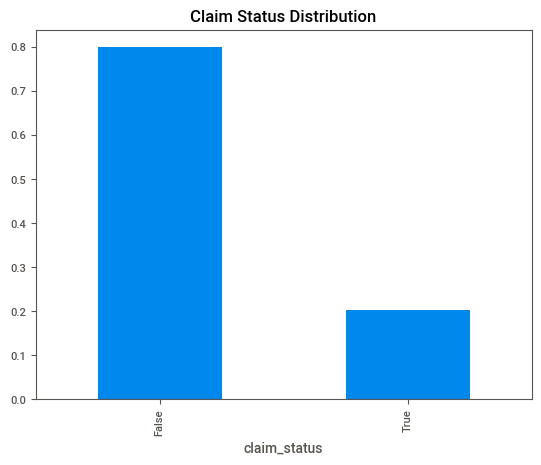

In [246]:
insurance_synth_data
insurance_synth_data['claim_status'].value_counts(normalize=True).plot(kind='bar', title='Claim Status Distribution')

600.0


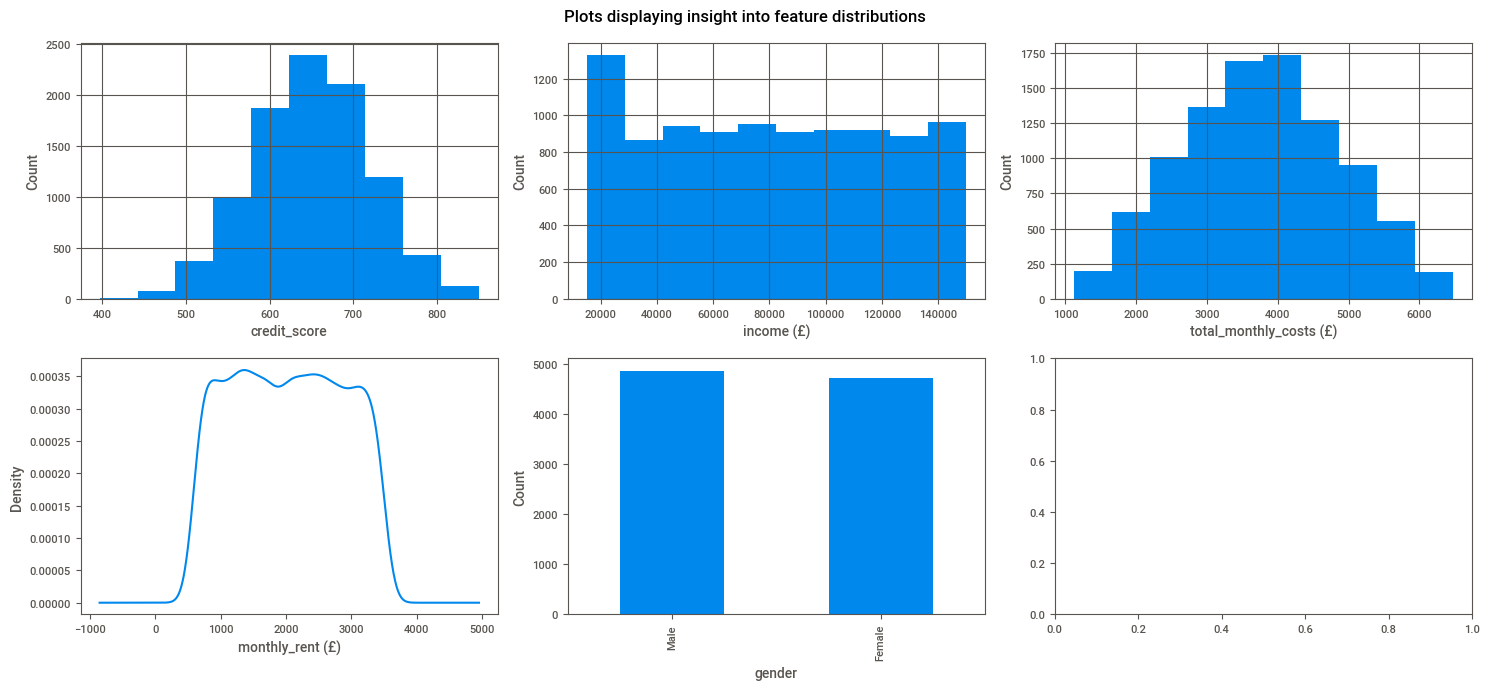

In [276]:
#Creating plots to visualise column values in graphs

fig, axs = plt.subplots(2, 3, figsize=(15,7))
insurance_synth_data['credit_score'].hist(ax=axs[0, 0])
axs[0, 0].set_ylabel('Count')
axs[0, 0].set_xlabel('credit_score')

insurance_synth_data['income'].hist(ax=axs[0, 1])
axs[0, 1].set_ylabel('Count')
axs[0, 1].set_xlabel('income (£)')

insurance_synth_data['total_monthly_costs'].hist(ax=axs[0, 2])
axs[0, 2].set_ylabel('Count')
axs[0, 2].set_xlabel('total_monthly_costs (£)')

print(insurance_synth_data['monthly_rent'].min())
insurance_synth_data['monthly_rent'].plot.density(ax=axs[1, 0])
axs[1, 0].set_ylabel('Density')
axs[1, 0].set_xlabel('monthly_rent (£)')

insurance_synth_data['gender'].value_counts().plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_ylabel('Count')

plt.suptitle('Plots displaying insight into feature distributions')
plt.tight_layout()
plt.show()

Graph Summaries
- Credit_score: Quite clear median value is roughly 650 here, distribution as it increased and reduces appears to follow a similar pattern
- Income: Spikes in the 20000-25000 and 70000-80000 ranges. Generally fairly evenly distributed otherwise
- total_monthly_costs: Showing a normal distribution with peaks in the middle of the values at roughly 3500-4000
- Monthly_rent: Larger density of values towards 2000 where it peaks
- Gender: As expected roughly even but a slightly higher proportion of male rather than female

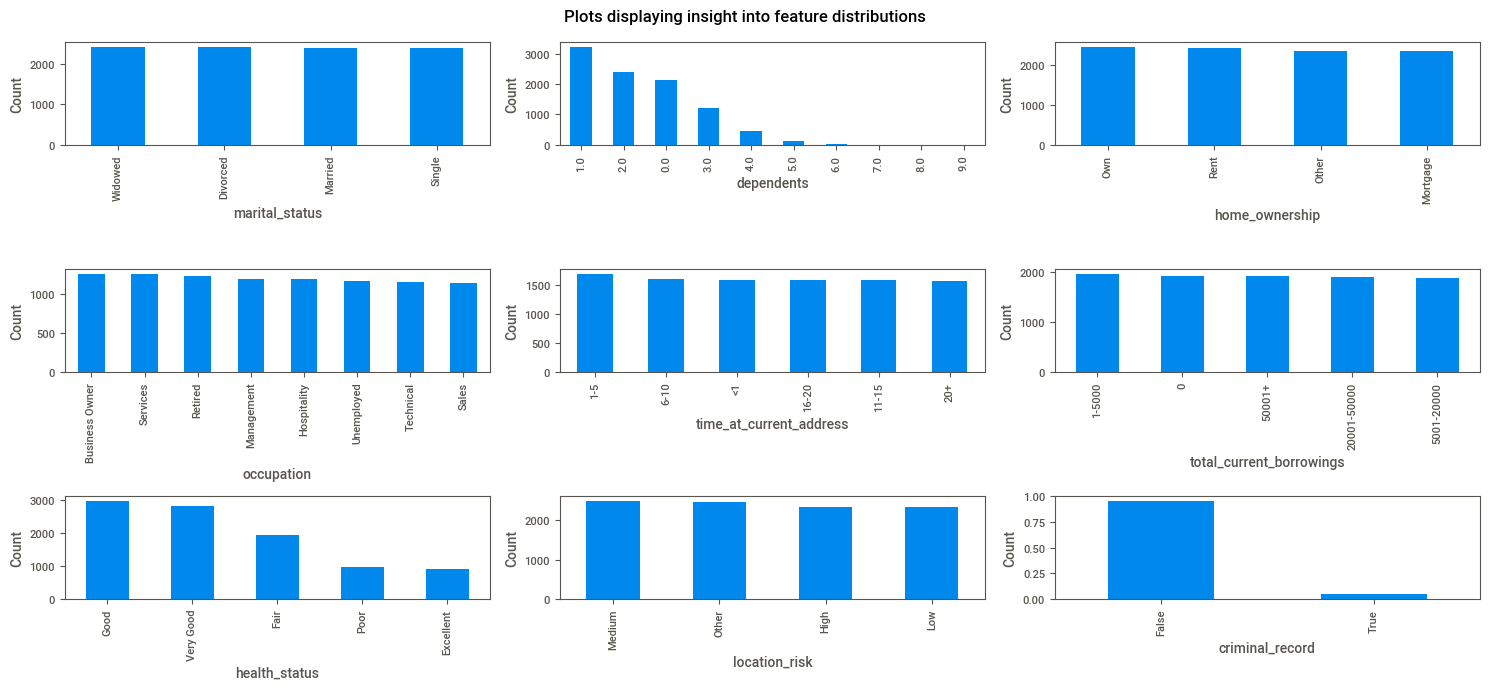

In [277]:
#Visualise more categorical fields in graphs

fig, axs = plt.subplots(3, 3, figsize=(15,7))
insurance_synth_data['marital_status'].value_counts().plot(kind='bar', ax=axs[0, 0])
axs[0, 0].set_ylabel('Count')

insurance_synth_data['dependents'].value_counts().plot(kind='bar', ax=axs[0, 1])
axs[0, 1].set_ylabel('Count')

insurance_synth_data['home_ownership'].value_counts().plot(kind='bar', ax=axs[0, 2])
axs[0, 2].set_ylabel('Count')

insurance_synth_data['occupation'].value_counts().plot(kind='bar', ax=axs[1, 0])
axs[1, 0].set_ylabel('Count')

insurance_synth_data['time_at_current_address'].value_counts().plot(kind='bar', ax=axs[1, 1])
axs[1, 1].set_ylabel('Count')

insurance_synth_data['total_current_borrowings'].value_counts().plot(kind='bar', ax=axs[1, 2])
axs[1, 2].set_ylabel('Count')

insurance_synth_data['health_status'].value_counts().plot(kind='bar', ax=axs[2, 0])
axs[2, 0].set_ylabel('Count')

insurance_synth_data['location_risk'].value_counts().plot(kind='bar', ax=axs[2, 1])
axs[2, 1].set_ylabel('Count')

insurance_synth_data['criminal_record'].value_counts(normalize=True).plot(kind='bar', ax=axs[2, 2])
axs[2, 2].set_ylabel('Count')
axs[2, 2].set_ylim(0, 1)

plt.suptitle('Plots displaying insight into feature distributions')
plt.tight_layout()
plt.show()

Graph Summaries
- Marital_status- Looks to be a fairly even distribution in this case, no particular pattern
- dependents- Majority of rows in 1,2 and 0 dependents (around 8000) in these 3 categories and as expected a reducing number, as the dependents increases beyond 3
- home_ownership- No real pattern, evenly distributed across the 4 categories
- occupation- Slightly larger total with the occupations 'business_owner' and 'services' but largely even across the 8 cats
- time_at_current_address- Highest number in the 1-5 years range, similar totals across the remainder of bins
- total_current_borrowings- Pretty even across the 5 categories ranging from 0 to 50001+
- Health_status: Good and very good health statuses make up around 6000 of the 10000. 3000 of those sit within either the fair or poor health categories which could be relevant
- Location_risk: Generally even split across the categories
- Criminal_record: Vast majority of potential customers have no criminal record (around 95%), whilst those with a criminal record, make up the remaining 5%

<Axes: title={'center': 'Claim Rate by Education'}, xlabel='location_risk'>

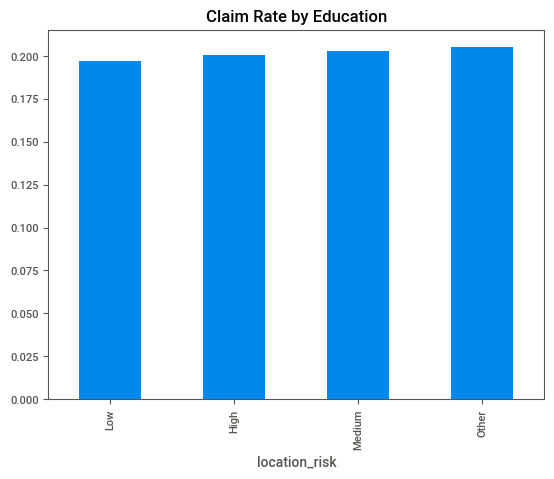

In [ ]:
#A few comparative examples of feature vs claim status or multivariate feature vs feature
#See what might be important features when it comes to being deterministic of the true/false classification feature
insurance_synth_data.groupby('location_risk')['claim_status'].mean().sort_values().plot(kind='bar', title='Claim Rate by Education')

Generally investigating the features vs the class had no real patterns (due to it being largely random) but this would typically be a good way to get an idea of what features we might expect to be important.

As well as those features that might be highly correlated with another feature with similar context

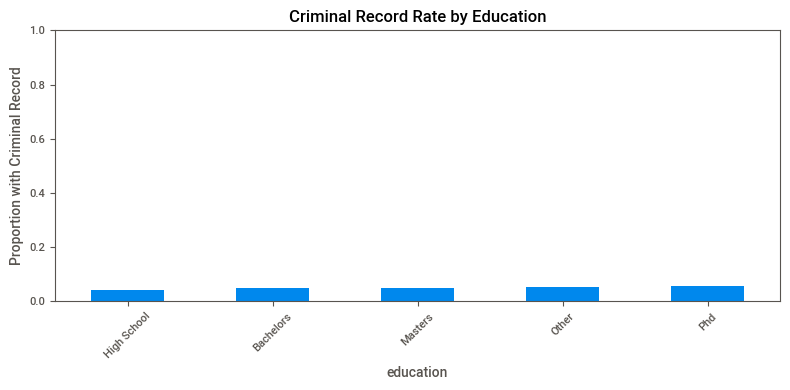

In [ ]:
#Compare two features that may have strong correlations, as you would assume those with higher education status are less likely to have a criminal record

crime_rate_by_education = (
    insurance_synth_data.groupby('education')['criminal_record']
    .mean()
    .sort_values()
)

crime_rate_by_education.plot(kind='bar', figsize=(8, 4), title='Criminal Record Rate by Education')
plt.ylabel('Proportion with Criminal Record')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Feature Imputation
Now we have done some initial analysis and handled missing features and duplication, now want to check the feature typing and encode those necessary for ML use case.

As features such as categoricals need to be numeric for use, now to determine encoding (method of translating categories into usable inputs to ML algorithms) method
- Either label encoding or one hot encoding. Generally if it has an order, label encoding and otherwise one hot encoding here

In [ ]:
print(insurance_synth_data.dtypes)
insurance_synth_data = insurance_synth_data.astype({'age': 'int', 'income': 'int', 'credit_score': 'int', 'dependents': 'int', 'monthly_rent': 'int', 'total_monthly_costs': 'int', 'criminal_record': 'int', 'claim_status': 'int'})

print(insurance_synth_data.head(10))
nominal_cols = ['gender', 'marital_status', 'occupation', 'employment_duration', 'home_ownership']
ordinal_cols = ['education', 'time_at_current_address', 'total_current_borrowings', 'health_status', 'driving_record', 'location_risk']

df = pd.get_dummies(insurance_synth_data, columns=nominal_cols, drop_first=True, dtype=int)
    
education_order = ['Other', 'High School', 'Bachelors', 'Masters', 'Phd']
df['education'] = pd.Categorical(df['education'], categories=education_order, ordered=True)
df['education'] = df['education'].cat.codes

time_curr_addr_ord = ['<1', '1-5', '6-10', '11-15', '16-20', '20+']
df['time_at_current_address'] = pd.Categorical(df['time_at_current_address'], categories=time_curr_addr_ord, ordered=True)
df['time_at_current_address'] = df['time_at_current_address'].cat.codes

current_borrowing_ord = ['0', '1-5000', '5001-20000', '20001-50000', '50001+']
df['total_current_borrowings'] = pd.Categorical(df['total_current_borrowings'], categories=current_borrowing_ord, ordered=True)
df['total_current_borrowings'] = df['total_current_borrowings'].cat.codes

health_order = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
df['health_status'] = pd.Categorical(df['health_status'], categories=health_order, ordered=True)
df['health_status'] = df['health_status'].cat.codes

driving_record_order = ['Bad', 'Average', 'Good', 'Excellent']
df['driving_record'] = pd.Categorical(df['driving_record'], categories=driving_record_order, ordered=True)
df['driving_record'] = df['driving_record'].cat.codes

location_risk_order = ['Bad', 'Average', 'Good', 'Excellent']
df['location_risk'] = pd.Categorical(df['location_risk'], categories=location_risk_order, ordered=True)
df['location_risk'] = df['location_risk'].cat.codes

prepped_data = df

print(prepped_data.head(10))
print(prepped_data.dtypes)

prepped_data = prepped_data.rename(columns={'employment_duration_<1': 'employment_duration_less_thn_1'})
prepped_data

customer_id                   int64
age                         float64
income                      float64
credit_score                float64
dependents                  float64
monthly_rent                float64
total_monthly_costs         float64
gender                       object
marital_status               object
education                    object
occupation                   object
time_at_current_address      object
total_current_borrowings     object
employment_duration          object
criminal_record              object
health_status                object
driving_record               object
home_ownership               object
location_risk                object
claim_status                   bool
dtype: object
   customer_id  age  income  credit_score  dependents  monthly_rent  \
0         1039   84   17000           651           2          2750   
1         1339   88  106000           676           2          1425   
2         4642   44  108000           673           1

,customer_id,age,income,credit_score,dependents,monthly_rent,total_monthly_costs,education,time_at_current_address,total_current_borrowings,...,occupation_Technical,occupation_Unemployed,employment_duration_11-15,employment_duration_16-20,employment_duration_20+,employment_duration_6-10,employment_duration_less_thn_1,home_ownership_Other,home_ownership_Own,home_ownership_Rent
0,1039,84,17000,651,2,2750,4923,3,1,2,...,0,1,0,0,0,1,0,0,0,1
1,1339,88,106000,676,2,1425,2169,4,1,4,...,0,0,0,0,0,1,0,0,0,1
2,4642,44,108000,673,1,2198,3900,3,3,2,...,0,1,0,0,0,0,1,1,0,0
3,1184,83,25000,608,2,2949,3800,1,1,3,...,0,0,0,1,0,0,0,0,0,0
4,7813,36,110000,619,0,2029,4553,0,1,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,7437,41,104000,661,1,1289,4283,2,3,3,...,1,0,0,1,0,0,0,0,0,1
10096,5897,21,15000,601,1,3132,4620,3,2,3,...,0,0,0,1,0,0,0,1,0,0
10097,929,54,35000,651,1,1436,4171,1,3,3,...,0,0,0,0,0,0,1,1,0,0
10098,5174,25,119000,637,2,796,1552,1,4,4,...,0,0,0,0,1,0,0,0,1,0


Data is now encoded, meaning all features are in a format suitable for ml model training (numeric here)

### Model Training
- Now that the data is handled and ready for ml training we can do final preparation and begin training the model

In [256]:
X = prepped_data.drop(columns=['claim_status', 'customer_id'])
y = prepped_data['claim_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

Data is split into 80/20 percent ratio for training and testing. Testing is set a side for 'blind' test on the trained model

[0.51538856 0.52440594 0.52537347 0.54298734 0.50321704 0.54199563
 0.5526191  0.4861353  0.51059445 0.50726096]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
XGB
Accuracy: 0.782
Precision: 0.25609756097560976
Recall: 0.05303030303030303
F1 Score: 0.08786610878661087
ROC AUC: 0.5050001259477569


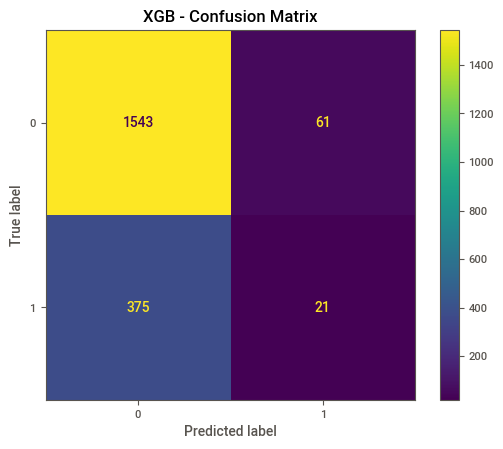

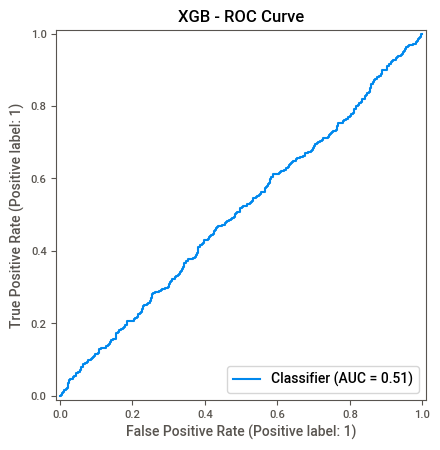

RF
Accuracy: 0.802
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.5105237222600065


c:\Users\xandi\anaconda3\envs\thg_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



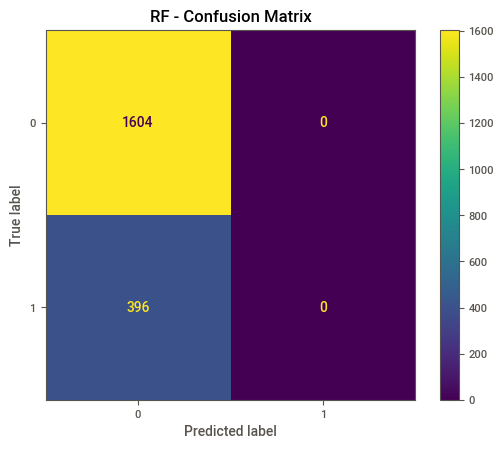

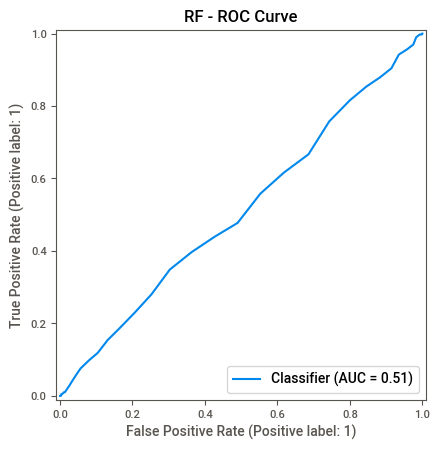

In [ ]:
model_rf = RandomForestClassifier(random_state=1)
model_xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc')

print(scores_rf)

model_xgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)

y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]

sorted_y_proba_xgb = np.argsort(y_proba_xgb)
sorted_y_proba_rf = np.argsort(y_proba_rf)

print(y_pred_xgb)
print(y_pred_rf)

def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"{model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_prob)
    plt.title(f"{model_name} - ROC Curve")
    plt.show()

evaluate_model(y_test, y_pred_xgb, y_proba_xgb, 'XGB')
evaluate_model(y_test, y_pred_rf, y_proba_rf, 'RF')

From the results we would be looking to find the best performing model based on the roc auc being as close to 1 as possible and f1 score (maybe different depending on class prediction importance) to ensure precision and recall are balanced well. For the case here the roc auc is clearly close to random at 0.51 but taking the larger roc auc of the two, RF here we could then look to find a threshold for the model where it allows through customers with a risk score that would ensure we are getting customers with roughly 5% of which predicting this

0.0 0.04
0.0 0.05
0.3333333333333333 0.060000000000000005
0.3333333333333333 0.06999999999999999
0.08333333333333333 0.08
0.12903225806451613 0.09
0.12903225806451613 0.09999999999999999
0.20481927710843373 0.11
0.18110236220472442 0.12
0.21714285714285714 0.13
0.2033898305084746 0.14
0.1895424836601307 0.15000000000000002
0.18527918781725888 0.16
0.1889763779527559 0.17
0.20754716981132076 0.18000000000000002
0.19869281045751633 0.19
0.1961883408071749 0.2
0.20195121951219513 0.21000000000000002
0.19456617002629273 0.22
0.1895321173671689 0.23
0.1875 0.24000000000000002
0.19204851752021562 0.25
0.1932826362484157 0.26
0.19374247894103488 0.27
0.19386574074074073 0.28
0.1954087346024636 0.29000000000000004
0.19486899563318777 0.3
0.19478445981905268 0.31
0.1959140911471975 0.32
0.1970010341261634 0.33
0.19763860369609856 0.34
0.19816607233825778 0.35000000000000003
0.19858156028368795 0.36000000000000004
0.19807983830217282 0.37
0.1981891348088531 0.38
0.19779116465863453 0.39
0.198193

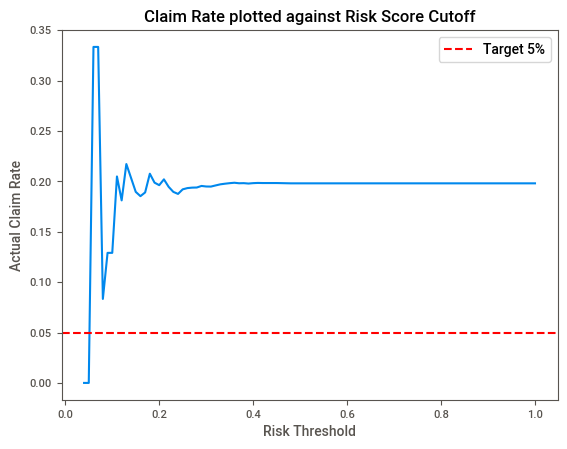

2025-05-09 15:12:51,313 - INFO     - Executing shutdown due to inactivity...
2025-05-09 15:12:55,403 - INFO     - Executing shutdown...
2025-05-09 15:12:55,407 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [271]:
thresholds = np.linspace(0.01, 1.0, 100)
claim_rates = []

for threshold in thresholds:
    selected = y_proba_rf <= threshold
    if selected.sum() == 0:
        claim_rates.append(np.nan)
        continue
    rate = y_test[selected].mean()
    print(rate, threshold)
    claim_rates.append(rate)

plt.plot(thresholds, claim_rates)
plt.axhline(0.05, color='red', linestyle='--', label='Target 5%')
plt.xlabel('Risk Threshold')
plt.ylabel('Actual Claim Rate')
plt.title('Claim Rate plotted against Risk Score Cutoff')
plt.legend()
plt.show()

Summary:

In a normal scenario, this would trend towards risk score threshold of 0.05 as the threshold changes. In this situation we never actually reach the 0.05 risk threshold due to the randomness of defined features, but in a more realistic situation this line would go through the 0.05 claim rate when the threshold for the model reduces. Here using the slight trough of 0.1 for the threshold would enable around an 8% claim rate on customers. You could then also look to optimise hyper parameters of the ML model (grid search of a range of key features relevant to the model to look for improvements)

Presenting the model, I would use the roc auc curve, the confusion matrix and the threshold graph so that we can explain the performance of the model including with class predictions breakdowns via the confusion matrix and then the threshold graph could be used as a clear way of determining what threshold we would like based off our potential number of claims

### Productionising

Question 1: Assuming the business likes your model, what are the next steps to go from a Jupyter Notebook to a
productionised service?

Firstly the jupyter notebook should be turned into a repeatable and structured pipeline that can be reused and rerun if necessary with clear functions created for each part of the process. You would then need to identify where the model would fit into the business processes, likely through discussing with key stakeholders. Then identification of existing cloud services where the model maybe best deployed to, for instance AWS based on compatibility and cost. Finally assessment of whether the model will be utilising a live or batch process to handle requests which is dependent on data volumes, current process and preference as well.


Question 2: What are the considerations for ensuring the business can leverage it?

Identifying ownership of the model after deployment as to who will monitor and at times retrain the model on new data. Where and how the business will utilise these predictions, ensuring stakeholders have a solid understanding of this. Whether you have permission or the ability to utilise the data of the customer for this (permissions). Ensure you have the infrastructure and worker bandwidth to review the results.


Question 3: What are the steps you would take to provide this to the business?

First perform model tuning and validation to ensure final performance and explainability checks. You could then take the analysis and results to present these in presentations or reports to stakeholders, providing clear justification of the model benefits. This report would also detail how to use the model correctly and the full process of model development.


Question 4: Which traditional teams in a business would you need to speak to?

Likely to the current insurance and risk teams to ensure the model is clear and represents a clear benefit to the team. As well as ensuring they understand how the model works and how they may utilise this. Justifying the model to management to ensure they understand the benefits of it. Speaking to MLOps or ML engineers about deployment of the model to the existing cloud platforms and ensuring the pipeline is repeatable.


Question 5: What is in scope and out of scope for your responsibility?
Producing the summary of the model and justifying its benefits to key stakeholders to prove it is worth using. Working with other teams to identify how it fits into current processes and how it will be used to calculate risk. Managing and reviewing performance and determining frequency that the model may need to be reviewed and tuned.

Areas out of scope would likely be complete deployment, as you may need MLOps or an engineer with knowledge and access to do so. Further business decisions on model thresholds based on bandwidth of investigators and risk team members. 

